In [1]:
# Import relevant libraries
import random
import string
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as pp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from lifetimes import BetaGeoFitter, ParetoNBDFitter
from lifetimes.utils import summary_data_from_transaction_data
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, HTML
display(HTML("<style>.container { width:500% !important; }</style>"))

In [2]:
# import the data
data = pd.read_csv(r'https://raw.githubusercontent.com/Lanreajayi74/netflix-cltv/refs/heads/main/Netflix%20Userbase.csv', encoding = 'utf-8')
df = pd.DataFrame(data)
df

,User ID,Subscription Type,Monthly Revenue,Join Date,Last Payment Date,Country,Age,Gender,Device,Plan Duration
0,1,Basic,10,15-01-22,10-06-23,United States,28,Male,Smartphone,1 Month
1,2,Premium,15,05-09-21,22-06-23,Canada,35,Female,Tablet,1 Month
2,3,Standard,12,28-02-23,27-06-23,United Kingdom,42,Male,Smart TV,1 Month
3,4,Standard,12,10-07-22,26-06-23,Australia,51,Female,Laptop,1 Month
4,5,Basic,10,01-05-23,28-06-23,Germany,33,Male,Smartphone,1 Month
...,...,...,...,...,...,...,...,...,...,...
2495,2496,Premium,14,25-07-22,12-07-23,Spain,28,Female,Smart TV,1 Month
2496,2497,Basic,15,04-08-22,14-07-23,Spain,33,Female,Smart TV,1 Month
2497,2498,Standard,12,09-08-22,15-07-23,United States,38,Male,Laptop,1 Month
2498,2499,Standard,13,12-08-22,12-07-23,Canada,48,Female,Tablet,1 Month


In [3]:
# About the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   User ID            2500 non-null   int64 
 1   Subscription Type  2500 non-null   object
 2   Monthly Revenue    2500 non-null   int64 
 3   Join Date          2500 non-null   object
 4   Last Payment Date  2500 non-null   object
 5   Country            2500 non-null   object
 6   Age                2500 non-null   int64 
 7   Gender             2500 non-null   object
 8   Device             2500 non-null   object
 9   Plan Duration      2500 non-null   object
dtypes: int64(3), object(7)
memory usage: 195.4+ KB


In [4]:
# Data transformation with feature engineering
df['sub_type'] = df['Subscription Type']
df['join_date'] = pd.to_datetime(df['Join Date'])
df['pay_date'] = pd.to_datetime(df['Last Payment Date'])
df.drop(columns = ['Plan Duration','User ID','Subscription Type',
                    'Join Date','Last Payment Date'],inplace=True)
df

,Monthly Revenue,Country,Age,Gender,Device,sub_type,join_date,pay_date
0,10,United States,28,Male,Smartphone,Basic,2022-01-15,2023-10-06
1,15,Canada,35,Female,Tablet,Premium,2021-05-09,2023-06-22
2,12,United Kingdom,42,Male,Smart TV,Standard,2023-02-28,2023-06-27
3,12,Australia,51,Female,Laptop,Standard,2022-10-07,2023-06-26
4,10,Germany,33,Male,Smartphone,Basic,2023-01-05,2023-06-28
...,...,...,...,...,...,...,...,...
2495,14,Spain,28,Female,Smart TV,Premium,2022-07-25,2023-12-07
2496,15,Spain,33,Female,Smart TV,Basic,2022-04-08,2023-07-14
2497,12,United States,38,Male,Laptop,Standard,2022-09-08,2023-07-15
2498,13,Canada,48,Female,Tablet,Standard,2022-12-08,2023-12-07


In [5]:
# Create a mapping of (Country, Subscription Type) to a unique code
country_sub_type_map = {}
for country in df['Country'].unique():
    for subtype in df['sub_type'].unique():
        random_code = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
        country_sub_type_map[(country, subtype)] = random_code

# Function to generate subscriber ID
def generate_subscriber_id(row):
    return country_sub_type_map[(row['Country'], row['sub_type'])]

# Apply the function to the dataframe
df['sub_id'] = df.apply(generate_subscriber_id, axis=1)
df = df[['sub_id','Country', 'Age','Gender','Device','sub_type','join_date','pay_date','Monthly Revenue']]
# Display the dataframe
df

,sub_id,Country,Age,Gender,Device,sub_type,join_date,pay_date,Monthly Revenue
0,BU0F4,United States,28,Male,Smartphone,Basic,2022-01-15,2023-10-06,10
1,BX69K,Canada,35,Female,Tablet,Premium,2021-05-09,2023-06-22,15
2,JINXH,United Kingdom,42,Male,Smart TV,Standard,2023-02-28,2023-06-27,12
3,XE95W,Australia,51,Female,Laptop,Standard,2022-10-07,2023-06-26,12
4,A8PYK,Germany,33,Male,Smartphone,Basic,2023-01-05,2023-06-28,10
...,...,...,...,...,...,...,...,...,...
2495,P19D7,Spain,28,Female,Smart TV,Premium,2022-07-25,2023-12-07,14
2496,0F4A2,Spain,33,Female,Smart TV,Basic,2022-04-08,2023-07-14,15
2497,7QV9K,United States,38,Male,Laptop,Standard,2022-09-08,2023-07-15,12
2498,0QT6Z,Canada,48,Female,Tablet,Standard,2022-12-08,2023-12-07,13


In [6]:
# Summary statistics from the table
df.describe()

,Age,Monthly Revenue
count,2500.000000,2500.000000
mean,38.795600,12.508400
std,7.171778,1.686851
min,26.000000,10.000000
25%,32.000000,11.000000
50%,39.000000,12.000000
75%,45.000000,14.000000
max,51.000000,15.000000


In [7]:
# Count distinct values for categorical columns
categorical_columns = ['Country', 'Gender', 'Device', 'sub_type']
distinct_counts = {col: df[col].nunique() for col in categorical_columns}
distinct_counts

{'Country': 10, 'Gender': 2, 'Device': 4, 'sub_type': 3}

Text(0, 0.5, 'Frequency')

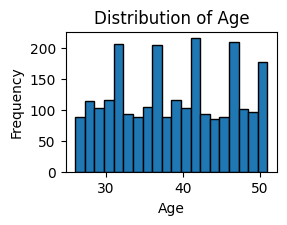

In [8]:
# Exploratory Data Analysis (univariate analysis on Age)
pp.figure(figsize=(6, 4))
pp.subplot(2, 2, 1)
pp.hist(df['Age'].dropna(), bins=20, edgecolor='k')
pp.title('Distribution of Age')
pp.xlabel('Age')
pp.ylabel('Frequency')

Text(0, 0.5, 'Frequency')

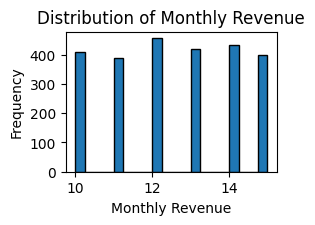

In [9]:
# Exploratory Data Analysis (univariate analysis on Monthly Revenue)
pp.figure(figsize=(6, 4))
pp.subplot(2, 2, 2)
pp.hist(df['Monthly Revenue'].dropna(), bins=20, edgecolor='k')
pp.title('Distribution of Monthly Revenue')
pp.xlabel('Monthly Revenue')
pp.ylabel('Frequency')

Text(0, 0.5, 'Count')

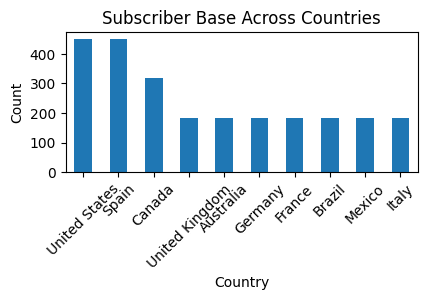

In [10]:
# Subscriber base by Country
pp.figure(figsize=(10, 4))
pp.subplot(2, 2, 3)
df['Country'].value_counts().plot(kind='bar', rot=45)
pp.title('Subscriber Base Across Countries')
pp.xlabel('Country')
pp.ylabel('Count')

Text(0, 0.5, 'Count')

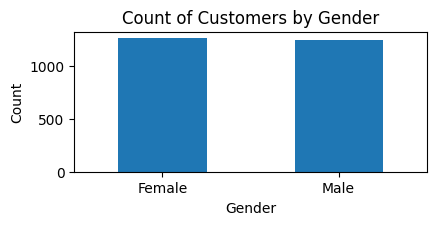

In [11]:
# Subscriber base by Gender
pp.figure(figsize=(10, 4))
pp.subplot(2, 2, 4)
df['Gender'].value_counts().plot(kind='bar', rot=0)
pp.title('Count of Customers by Gender')
pp.xlabel('Gender')
pp.ylabel('Count')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'United States'),
  Text(1, 0, 'Canada'),
  Text(2, 0, 'United Kingdom'),
  Text(3, 0, 'Australia'),
  Text(4, 0, 'Germany'),
  Text(5, 0, 'France'),
  Text(6, 0, 'Brazil'),
  Text(7, 0, 'Mexico'),
  Text(8, 0, 'Spain'),
  Text(9, 0, 'Italy')])

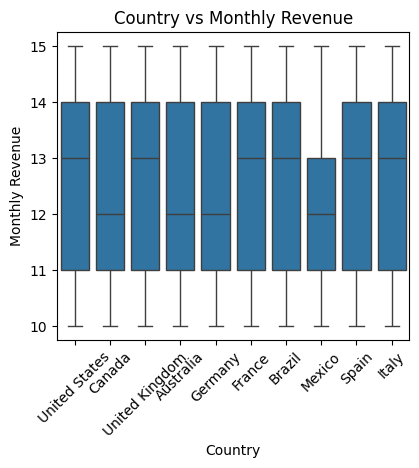

In [12]:
# EDA on Monthly Revenue Distribution by Country
pp.figure(figsize=(10, 4))
pp.subplot(1, 2, 2)
sns.boxplot(x='Country', y='Monthly Revenue', data=df)
pp.title('Country vs Monthly Revenue')
pp.xticks(rotation=45)

In [13]:
# Correlation matrix
correlation_matrix = df[['Age', 'Monthly Revenue']].corr()
correlation_matrix

,Age,Monthly Revenue
Age,1.000000,-0.021143
Monthly Revenue,-0.021143,1.000000


In [14]:
# Steps taken to derive the RFM table
deriv = df.copy()

deriv = deriv.sort_values(by=['sub_id', 'pay_date'])

deriv['Previous_pay_date'] = deriv.groupby('sub_id')['pay_date'].shift(1)
deriv['Recency'] = (deriv['pay_date'] - deriv['Previous_pay_date']).dt.days

max_recency = deriv['Recency'].max()
deriv['Recency'] = deriv['Recency'].fillna(max_recency + 1)

frequency_df = deriv.groupby('sub_id').size().reset_index(name='Frequency')
monetary_df = deriv.groupby('sub_id')['Monthly Revenue'].sum().reset_index(name='Monetary')

rfm_df = pd.merge(frequency_df, monetary_df, on='sub_id')
rfm_df = pd.merge(rfm_df, deriv[['sub_id', 'Recency']].drop_duplicates(), on='sub_id')

In [15]:
# Calculate RFM Score
rfm_df['R'] = pd.qcut(rfm_df['Recency'], 4, ['4', '3', '2', '1'])
rfm_df['F'] = pd.qcut(rfm_df['Frequency'].rank(method='first'), 4, ['1', '2', '3', '4'])
rfm_df['M'] = pd.qcut(rfm_df['Monetary'], 4, ['1', '2', '3', '4'])
rfm_df['RFM Score'] = rfm_df[['R', 'F', 'M']].sum(axis=1)
# Calculate T for CLV estimation
rfm_df['T'] = (df['pay_date'].max() - df['join_date'].min()).days
rfm_df

,sub_id,Frequency,Monetary,Recency,R,F,M,RFM Score,T
0,08PN5,31,391,62.0,1,1,1,111.0,942
1,08PN5,31,391,31.0,1,1,1,111.0,942
2,08PN5,31,391,0.0,4,1,1,411.0,942
3,08PN5,31,391,28.0,2,1,1,211.0,942
4,08PN5,31,391,30.0,2,1,1,211.0,942
...,...,...,...,...,...,...,...,...,...
229,YNTQZ,179,2191,16.0,3,4,4,344.0,942
230,YNTQZ,179,2191,1.0,4,4,4,444.0,942
231,YNTQZ,179,2191,7.0,3,4,4,344.0,942
232,YNTQZ,179,2191,6.0,3,4,4,344.0,942


In [16]:
# Define segments
def segment_customer(df):
    r = df['R']
    f = df['F']
    m = df['M']
    
    if r  in ['1', '2'] and f == '4' and m == '4':
        return 'Watch List'
    elif r in ['2', '3'] and f in ['3', '4'] and m in ['3', '4']:
        return 'Loyal Subscribers'
    elif r in ['1', '2'] and f  in ['1', '2', '3'] and m in ['1','2', '3']:
        return 'Dormant Subscribers'
    elif r == '1' and f == '1' and m in ['1', '2', '3', '4']:
        return 'First-Time Subscribers'
    elif r in ['1', '2'] and f == '1' and m in ['1', '2']:
        return 'Emerging Subscribers'
    elif r in ['3', '4'] and f in ['2', '3'] and m in ['2', '3']:
        return 'Critical Subscribers'
    elif r == '4' and f == '4' and m == '4':
        return 'Elite Subscribers'
    elif r == '4' and f == '4' and m == '3':
        return 'Potential Loyalists'
    elif r in ['1', '2'] and f in ['1', '2'] and m in ['3', '4']:
        return 'Fading Subscribers'
    elif r == '1' and f == '1' and m in ['1', '2']:
        return 'Lost Subscribers'
    else:
        return 'Others'

# Apply the segmentation function
rfm_df['Segment'] = rfm_df.apply(segment_customer, axis=1)

rfm_df

,sub_id,Frequency,Monetary,Recency,R,F,M,RFM Score,T,Segment
0,08PN5,31,391,62.0,1,1,1,111.0,942,Dormant Subscribers
1,08PN5,31,391,31.0,1,1,1,111.0,942,Dormant Subscribers
2,08PN5,31,391,0.0,4,1,1,411.0,942,Others
3,08PN5,31,391,28.0,2,1,1,211.0,942,Dormant Subscribers
4,08PN5,31,391,30.0,2,1,1,211.0,942,Dormant Subscribers
...,...,...,...,...,...,...,...,...,...,...
229,YNTQZ,179,2191,16.0,3,4,4,344.0,942,Loyal Subscribers
230,YNTQZ,179,2191,1.0,4,4,4,444.0,942,Elite Subscribers
231,YNTQZ,179,2191,7.0,3,4,4,344.0,942,Loyal Subscribers
232,YNTQZ,179,2191,6.0,3,4,4,344.0,942,Loyal Subscribers


In [17]:
# Grouping by 'Segment' and calculating mean for each group
grouped_metrics = rfm_df.groupby('Segment').agg({
    'Monetary': 'mean',
    'Frequency': 'mean'
}).reset_index()

# Renaming columns for clarity
grouped_metrics.columns = ['Segment', 'Average_Monetary', 'Average_Frequency']

grouped_metrics.sort_values(by='Average_Monetary',ascending = False,ignore_index=True)

,Segment,Average_Monetary,Average_Frequency
0,Watch List,2378.000000,189.576923
1,Elite Subscribers,2375.333333,189.250000
2,Loyal Subscribers,1974.653061,157.755102
3,Potential Loyalists,1833.000000,149.000000
4,Critical Subscribers,1315.560976,105.292683
5,Dormant Subscribers,945.416667,75.736111
6,Others,241.212121,19.454545


In [18]:
# Create summary data from transaction data
summary = summary_data_from_transaction_data(df, 
'sub_id', 'pay_date', monetary_value_col='Monthly Revenue', 
                observation_period_end=df['pay_date'].max())

summary = summary.fillna(0)

# Adding additional columns for recency, frequency, monetary, and T 
#(calculated based on maximum observation period end) and to ensure that rf are consistent
summary['Recency'] = summary['recency']
summary['Frequency'] = summary['frequency']
summary['Monetary'] = summary['monetary_value']
summary['T'] = summary['T']

# Display summary
summary

,frequency,recency,T,monetary_value,Recency,Frequency,Monetary
sub_id,,,,,,,
08PN5,18.0,304.0,334.0,20.888889,304.0,18.0,20.888889
0F4A2,18.0,334.0,334.0,69.888889,334.0,18.0,69.888889
0JXDB,20.0,334.0,334.0,76.150000,334.0,20.0,76.150000
0QT6Z,18.0,334.0,334.0,55.333333,334.0,18.0,55.333333
1JSIP,19.0,334.0,334.0,89.368421,334.0,19.0,89.368421
337HB,2.0,4.0,166.0,18.500000,4.0,2.0,18.500000
3FNS9,2.0,4.0,166.0,18.000000,4.0,2.0,18.000000
4UA6K,22.0,334.0,334.0,97.090909,334.0,22.0,97.090909
6T9GL,16.0,304.0,334.0,27.125000,304.0,16.0,27.125000


In [19]:
# Function to partition the data into train, validation and test
train, temp = train_test_split(summary, test_size=0.4, random_state=42)
validation, test = train_test_split(temp, test_size=0.5, random_state=42)
train.shape, validation.shape, test.shape

((16, 7), (5, 7), (6, 7))

In [20]:
# Mirror the partitioned data for the BG/NBD prediction model
bgf_train = train.copy()
bgf_validation = validation.copy()
bgf_test = test.copy()

In [21]:
# Initialize and fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=10)
bgf.fit(bgf_train['Frequency'], bgf_train['Recency'], bgf_train['T'])
# Summary of fitted parameters
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.179022,0.036745,0.107002,0.251042
alpha,0.981141,0.690007,-0.371273,2.333555
a,0.025766,0.014468,-0.002592,0.054123
b,0.087193,0.035697,0.017227,0.157160


In [22]:
# Evaluate the model on validation data. The bgf_validation['T'] is taken to be 6 months
bgf_validation['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    bgf_validation['T'],
    bgf_validation['Frequency'],
    bgf_validation['Recency'],
    bgf_validation['Monetary']
)

In [23]:
# BG/BND model CLV prediction,assuming the average monetary value for each customer is stable over time
bgf_time_period = 182.5 

bgf_test['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    bgf_time_period, bgf_test['Frequency'], bgf_test['Recency'], bgf_test['T']).round(0).astype(int)

bgf_test['predicted_CLV'] = bgf_test['predicted_purchases'] * (bgf_test['Monetary'] / bgf_test['Frequency'])
bgf_test['Purchase Value'] = bgf_test['predicted_CLV']/bgf_test['predicted_purchases']
bgf_test[['predicted_purchases','Purchase Value', 'predicted_CLV']].sort_values(by = ['Purchase Value'],ascending=False)

,predicted_purchases,Purchase Value,predicted_CLV
sub_id,,,
BU0F4,12,4.778926,57.347107
0F4A2,10,3.882716,38.827160
7QV9K,10,3.879630,38.796296
8X8LY,12,3.555785,42.669421
6T9GL,9,1.695312,15.257812
VI7AG,10,1.457031,14.570312


In [24]:
bgf_df = bgf_test[['predicted_purchases','Purchase Value', 'predicted_CLV']].sort_values(by = ['Purchase Value'],ascending=False).copy()
# Resetting the index to make 'sub_id' a column
bgf_df.reset_index(inplace=True)
bgf_df.rename(columns={'index': 'sub_id'}, inplace=True)
bgf_df

,sub_id,predicted_purchases,Purchase Value,predicted_CLV
0,BU0F4,12,4.778926,57.347107
1,0F4A2,10,3.882716,38.827160
2,7QV9K,10,3.879630,38.796296
3,8X8LY,12,3.555785,42.669421
4,6T9GL,9,1.695312,15.257812
5,VI7AG,10,1.457031,14.570312


In [25]:
bgf_merged_df = pd.merge(df[['sub_id', 'Country', 'Age', 'Gender', 'Device', 'sub_type']], bgf_df, on='sub_id', how='inner')
bgf_merged_df = bgf_merged_df.drop_duplicates()
bgf_merged_df = bgf_merged_df.reset_index(drop=True)
bgf_merged_df

,sub_id,Country,Age,Gender,Device,sub_type,predicted_purchases,Purchase Value,predicted_CLV
0,BU0F4,United States,28,Male,Smartphone,Basic,12,4.778926,57.347107
1,BU0F4,United States,31,Female,Smartphone,Basic,12,4.778926,57.347107
2,BU0F4,United States,27,Male,Smartphone,Basic,12,4.778926,57.347107
3,BU0F4,United States,30,Female,Laptop,Basic,12,4.778926,57.347107
4,BU0F4,United States,45,Male,Tablet,Basic,12,4.778926,57.347107
...,...,...,...,...,...,...,...,...,...
460,7QV9K,United States,51,Male,Smart TV,Standard,10,3.879630,38.796296
461,7QV9K,United States,51,Female,Tablet,Standard,10,3.879630,38.796296
462,7QV9K,United States,49,Female,Smart TV,Standard,10,3.879630,38.796296
463,7QV9K,United States,48,Female,Smartphone,Standard,10,3.879630,38.796296


In [26]:
bgf_test_mae = mean_absolute_error(bgf_test['Monetary'], bgf_test['predicted_CLV'])
bgf_test_mse = mean_squared_error(bgf_test['Monetary'], bgf_test['predicted_CLV'])
bgf_test_rmse = np.sqrt(bgf_test_mse)
print(f'Mean Absolute Error: {bgf_test_mae}')
print(f'Mean Squared Error: {bgf_test_mse}')
print(f'Root Mean Squared Error: {bgf_test_rmse}')

Mean Absolute Error: 27.675874645019217
Mean Squared Error: 948.926402191004
Root Mean Squared Error: 30.804649035348607


In [28]:
# Mirror the partitioned data for the Pareto CLV prediction model
pareto_train = train.copy()
pareto_validation = validation.copy()
pareto_test = test.copy()

In [29]:
# Initialize and fit the Pareto/NBD model
pareto_fitter = ParetoNBDFitter(penalizer_coef=10)
pareto_fitter.fit(pareto_train['Frequency'], pareto_train['Recency'], pareto_train['T'])

# Retrieve model parameters
params = pareto_fitter.params_

# Create the summary DataFrame with available data
summary_df = pd.DataFrame(index=params.index)
summary_df['coef'] = params

summary_df

,coef
r,0.601319
alpha,5.892742
s,0.072641
beta,1.795241


In [30]:
# Define the time period (6 months)
pareto_time_period = 182.5

# Convert DataFrame columns to numpy arrays to avoid issues with mixed inputs
frequency = pareto_test['Frequency'].values
recency = pareto_test['Recency'].values
T = pareto_test['T'].values

# Predict the number of purchases
pareto_test['predicted_purchases'] = pareto_fitter.conditional_expected_number_of_purchases_up_to_time(
    pareto_time_period, frequency, recency, T
)
pareto_test['predicted_CLV'] = pareto_test['predicted_purchases'] * (pareto_test['Monetary'] / pareto_test['Frequency'])
pareto_test['purchase value'] = pareto_test['predicted_CLV']/pareto_test['predicted_purchases']

In [31]:
pareto_df = pareto_test[['predicted_purchases' ,'purchase value','predicted_CLV']].sort_values(by = ['purchase value'],ascending=False).copy()
# Resetting the index to make 'sub_id' a column
pareto_df.reset_index(inplace=True)
pareto_df.rename(columns={'index': 'sub_id'}, inplace=True)
pareto_df

,sub_id,predicted_purchases,purchase value,predicted_CLV
0,BU0F4,11.932524,4.778926,57.024643
1,0F4A2,9.820696,3.882716,38.130973
2,7QV9K,9.820696,3.879630,38.100662
3,8X8LY,11.932524,3.555785,42.429490
4,6T9GL,8.625160,1.695312,14.622342
5,VI7AG,9.630310,1.457031,14.031662


In [32]:
pareto_merged_df = pd.merge(df[['sub_id', 'Country', 'Age', 'Gender', 'Device', 'sub_type']], pareto_df, on='sub_id', how='inner')
pareto_merged_df = pareto_merged_df.drop_duplicates()
pareto_merged_df = pareto_merged_df.reset_index(drop=True)
pareto_merged_df

,sub_id,Country,Age,Gender,Device,sub_type,predicted_purchases,purchase value,predicted_CLV
0,BU0F4,United States,28,Male,Smartphone,Basic,11.932524,4.778926,57.024643
1,BU0F4,United States,31,Female,Smartphone,Basic,11.932524,4.778926,57.024643
2,BU0F4,United States,27,Male,Smartphone,Basic,11.932524,4.778926,57.024643
3,BU0F4,United States,30,Female,Laptop,Basic,11.932524,4.778926,57.024643
4,BU0F4,United States,45,Male,Tablet,Basic,11.932524,4.778926,57.024643
...,...,...,...,...,...,...,...,...,...
460,7QV9K,United States,51,Male,Smart TV,Standard,9.820696,3.879630,38.100662
461,7QV9K,United States,51,Female,Tablet,Standard,9.820696,3.879630,38.100662
462,7QV9K,United States,49,Female,Smart TV,Standard,9.820696,3.879630,38.100662
463,7QV9K,United States,48,Female,Smartphone,Standard,9.820696,3.879630,38.100662


In [33]:
pareto_test_mae = mean_absolute_error(pareto_test['Monetary'], pareto_test['predicted_CLV'])
pareto_test_mse = mean_squared_error(pareto_test['Monetary'], pareto_test['predicted_CLV'])
pareto_test_rmse = np.sqrt(pareto_test_mse)
print(f'Mean Absolute Error: {pareto_test_mae}')
print(f'Mean Squared Error: {pareto_test_mse}')
print(f'Root Mean Squared Error: {pareto_test_rmse}')

Mean Absolute Error: 28.197264221140617
Mean Squared Error: 975.6994839145997
Root Mean Squared Error: 31.236188690597317


In [34]:
# Define segments and transition function
segments = rfm_df['Segment'].unique()

# Calculate the transition matrix
def calculate_transition_matrix(df, segments):
    transition_matrix = pd.DataFrame(0, index=segments, columns=segments, dtype=float)
    for sub in df['sub_id'].unique():
        customer_data = df[df['sub_id'] == sub].sort_values(by='Recency')
        for i in range(len(customer_data) - 1):
            from_segment = customer_data.iloc[i]['Segment']
            to_segment = customer_data.iloc[i + 1]['Segment']
            transition_matrix.loc[from_segment, to_segment] += 1
    transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)
    return transition_matrix.fillna(0)

In [35]:
# Calculate transition matrix
transition_matrix = calculate_transition_matrix(rfm_df, segments)
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0).fillna(0)
print("Transition Matrix:")
transition_matrix

Transition Matrix:


,Dormant Subscribers,Others,Critical Subscribers,Loyal Subscribers,Watch List,Elite Subscribers,Potential Loyalists
Dormant Subscribers,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
Others,0.303030,0.69697,0.000000,0.000000,0.000000,0.000000,0.00000
Critical Subscribers,0.146341,0.00000,0.707317,0.121951,0.000000,0.000000,0.02439
Loyal Subscribers,0.122449,0.00000,0.000000,0.775510,0.102041,0.000000,0.00000
Watch List,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.00000
Elite Subscribers,0.000000,0.00000,0.000000,0.416667,0.000000,0.583333,0.00000
Potential Loyalists,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.00000


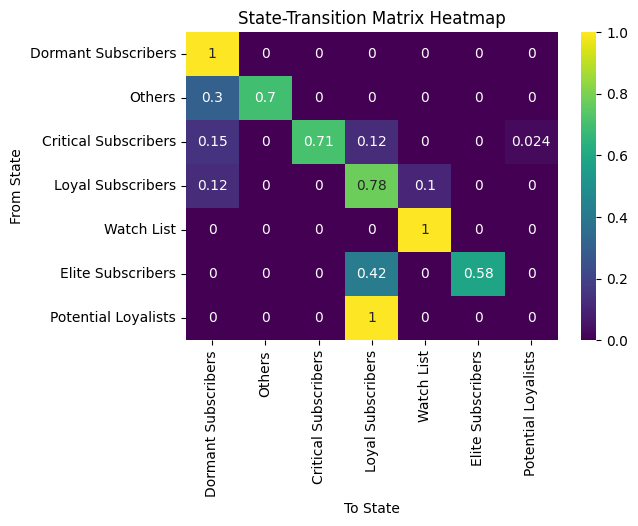

In [36]:
# Plot the heatmap of the transition matrix
pp.figure(figsize=(6, 4))
sns.heatmap(transition_matrix, annot=True, cmap="viridis", cbar=True)
pp.title('State-Transition Matrix Heatmap')
pp.xlabel('To State')
pp.ylabel('From State')
pp.show()

In [37]:
# Calculate the steady-state distribution
def compute_steady_state(transition_matrix):
    eigvals, eigvecs = np.linalg.eig(transition_matrix.T)
    eigvec = eigvecs[:, np.isclose(eigvals, 1)]
    eigvec = eigvec[:, 0]
    steady_state = eigvec / eigvec.sum()
    return steady_state.real
steady_state = compute_steady_state(transition_matrix.values)
print("Steady-state distribution:")
for state, prob in zip(transition_matrix.index, steady_state):
    print(f"{state}: {prob:.4f}")

Steady-state distribution:
Dormant Subscribers: 1.0000
Others: 0.0000
Critical Subscribers: 0.0000
Loyal Subscribers: 0.0000
Watch List: 0.0000
Elite Subscribers: 0.0000
Potential Loyalists: 0.0000


In [38]:
# Define the function to predict future distribution
def predict_future_distribution(transition_matrix, steps, initial_distribution):
    future_distribution = np.linalg.matrix_power(transition_matrix.values, steps).dot(initial_distribution)
    return future_distribution
    
transition_matrix = transition_matrix.div(transition_matrix.sum(axis=1), axis=0)

rfm_df = pd.DataFrame({'Segment': ['Potential Loyalists', 'Watch List', 'Loyal Subscribers', 'Elite Subscribers', 'Dormant Subscribers']})
initial_distribution = rfm_df['Segment'].value_counts(normalize=True).reindex(transition_matrix.index, fill_value=0).values

steps_list = [5, 10, 20, 50, 100]

results = {}

for steps in steps_list:
    future_distribution = predict_future_distribution(transition_matrix, steps, initial_distribution)
    results[steps] = future_distribution

results_df = pd.DataFrame(results, index=transition_matrix.index)

results_df

,5,10,20,50,100
Dormant Subscribers,0.200000,0.200000,0.200000,0.2,0.2
Others,0.167107,0.194590,0.199854,0.2,0.2
Critical Subscribers,0.164592,0.193731,0.199804,0.2,0.2
Loyal Subscribers,0.200000,0.200000,0.200000,0.2,0.2
Watch List,0.200000,0.200000,0.200000,0.2,0.2
Elite Subscribers,0.200000,0.200000,0.200000,0.2,0.2
Potential Loyalists,0.200000,0.200000,0.200000,0.2,0.2


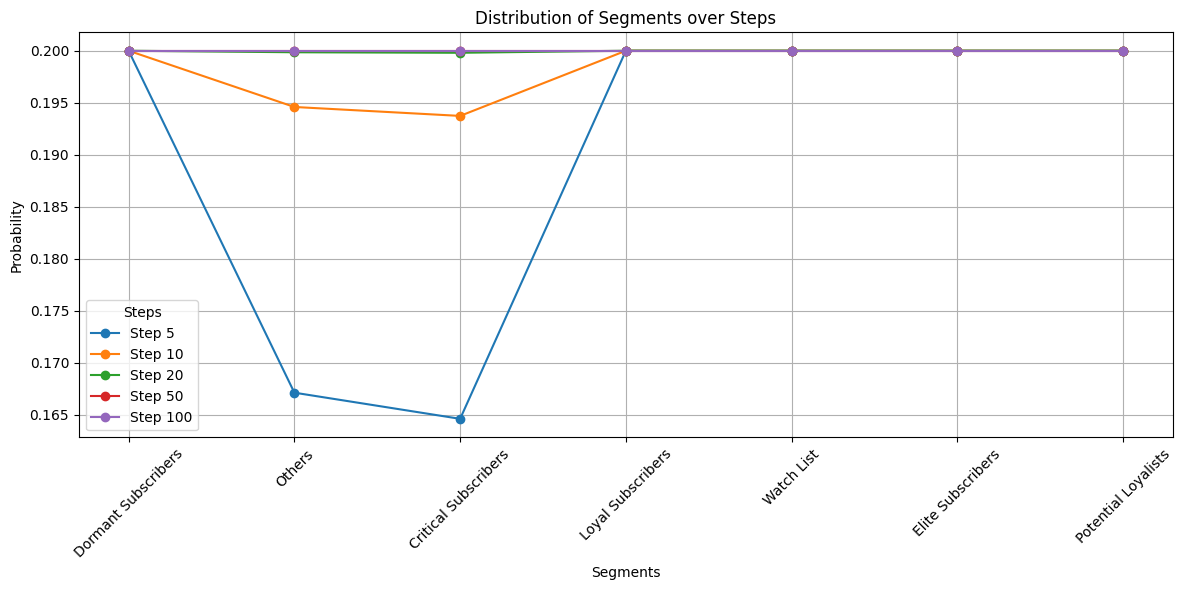

In [39]:
# Plot the distribution
pp.figure(figsize=(12, 6))
for step in results_df.columns:
    pp.plot(results_df.index, results_df[step], marker='o', label=f'Step {step}')
pp.title('Distribution of Segments over Steps')
pp.xlabel('Segments')
pp.ylabel('Probability')
pp.legend(title='Steps')
pp.xticks(rotation=45)
pp.grid(True)
pp.tight_layout()
pp.show()

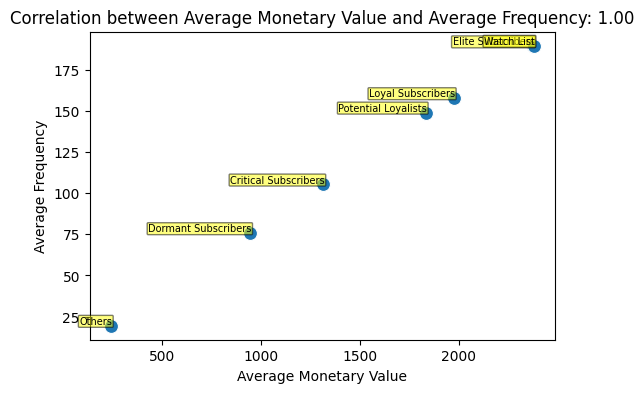

In [40]:
# Calculate the correlation between average monetary value and average frequency
correlation = grouped_metrics['Average_Monetary'].corr(grouped_metrics['Average_Frequency'])

pp.figure(figsize=(6, 4))
sns.scatterplot(x='Average_Monetary', y='Average_Frequency', data=grouped_metrics, s=100)

pp.xlabel('Average Monetary Value')
pp.ylabel('Average Frequency')
pp.title(f'Correlation between Average Monetary Value and Average Frequency: {correlation:.2f}')

for i, row in grouped_metrics.iterrows():
    pp.annotate(row['Segment'], 
                 (row['Average_Monetary'], row['Average_Frequency']),
                 textcoords="offset points", 
                 xytext=(1, 1),  
                 ha='right', 
                 fontsize=7, 
                 bbox=dict(boxstyle="round,pad=0.1", edgecolor="black", facecolor="yellow", alpha=0.5))
pp.show()

In [41]:
# Obtain a dataframe for the expected revenue per transition state (Segment)
grouped_metrics['Expected Revenue per State'] = grouped_metrics['Average_Monetary'] * grouped_metrics['Average_Frequency']
grouped_metrics.sort_values(by='Average_Monetary',ascending = False,ignore_index=True)

,Segment,Average_Monetary,Average_Frequency,Expected Revenue per State
0,Watch List,2378.000000,189.576923,450813.923077
1,Elite Subscribers,2375.333333,189.250000,449531.833333
2,Loyal Subscribers,1974.653061,157.755102,311511.595169
3,Potential Loyalists,1833.000000,149.000000,273117.000000
4,Critical Subscribers,1315.560976,105.292683,138518.944676
5,Dormant Subscribers,945.416667,75.736111,71602.181713
6,Others,241.212121,19.454545,4692.672176


In [42]:
# Calculate correlation coefficients
corr_monetary_expected = grouped_metrics['Expected Revenue per State'].corr(grouped_metrics['Average_Monetary'])
corr_monetary_expected

0.9749391398337222

In [43]:
corr_frequency_expected = grouped_metrics['Expected Revenue per State'].corr(grouped_metrics['Average_Frequency'])
corr_frequency_expected

0.9733205438285886

Text(0.05, 0.95, 'R² = 0.95')

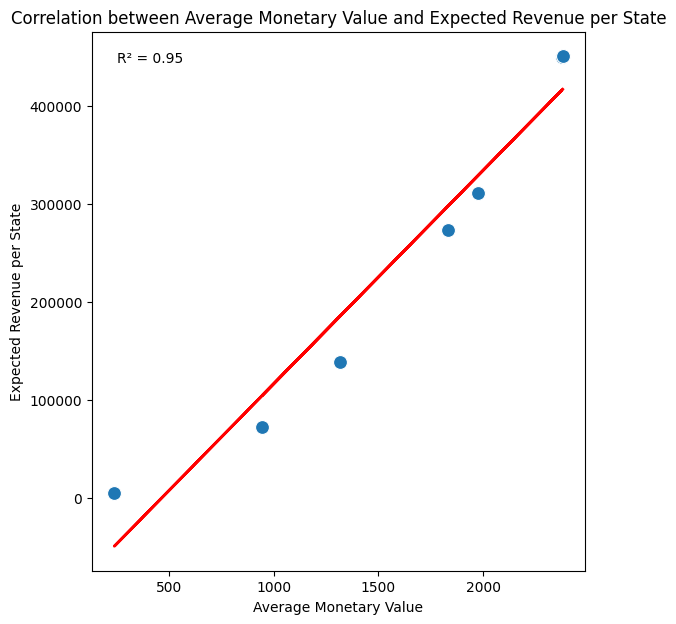

In [44]:
# Prepare the plot
pp.figure(figsize=(14, 7))
pp.subplot(1, 2, 1)
sns.scatterplot(x='Average_Monetary', y='Expected Revenue per State', data=grouped_metrics, s=100)
pp.xlabel('Average Monetary Value')
pp.ylabel('Expected Revenue per State')
pp.title("Correlation between Average Monetary Value and Expected Revenue per State")

X_monetary = grouped_metrics['Average_Monetary'].values.reshape(-1, 1)
y_expected = grouped_metrics['Expected Revenue per State'].values
reg_monetary = LinearRegression().fit(X_monetary, y_expected)
y_pred_monetary = reg_monetary.predict(X_monetary)
r_squared_monetary = reg_monetary.score(X_monetary, y_expected)
pp.plot(grouped_metrics['Average_Monetary'], y_pred_monetary, color='red', linewidth=2)
pp.text(0.05, 0.95, f'R² = {r_squared_monetary:.2f}', ha='left', va='center', transform=pp.gca().transAxes)

Text(0.05, 0.95, 'R² = 0.95')

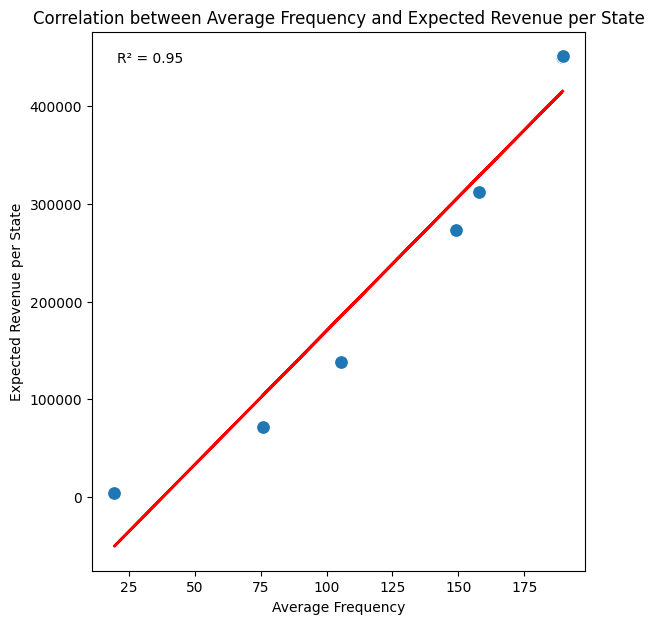

In [43]:
# Prepare the plot
pp.figure(figsize=(14, 7))
pp.subplot(1, 2, 1)
sns.scatterplot(x='Average_Frequency', y='Expected Revenue per State', data=grouped_metrics, s=100)
pp.xlabel('Average Frequency')
pp.ylabel('Expected Revenue per State')
pp.title("Correlation between Average Frequency and Expected Revenue per State")

X_frequency = grouped_metrics['Average_Frequency'].values.reshape(-1, 1)
y_expected = grouped_metrics['Expected Revenue per State'].values
reg_frequency = LinearRegression().fit(X_frequency, y_expected)
y_pred_frequency = reg_frequency.predict(X_frequency)
r_squared_frequency = reg_frequency.score(X_frequency, y_expected)
pp.plot(grouped_metrics['Average_Frequency'], y_pred_frequency, color='red', linewidth=2)
pp.text(0.05, 0.95, f'R² = {r_squared_frequency:.2f}', ha='left', va='center', transform=pp.gca().transAxes)